In [1]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import pycuda.gpuarray as gpuarray
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
from numpy import matmul as MM
from sklearn.metrics import normalized_mutual_info_score as nmi
import skcuda.linalg as LA
import skcuda
import time
import pycuda.driver as drv
LA.init()

In [2]:
def load_dataset(name='seeds'):
    if name == 'seeds':
        with open('datasets/seeds_dataset.txt') as ds:
            lines = ds.readlines()
            X = []
            Y = []
            for line in lines:
                x = line.split()
                y = x[-1]
                x = x[:-1]
                X.append(x)
                Y.append(y)
            X = np.array(X, dtype=np.float)
            Y = np.array(Y, dtype=np.uint8)
            return X, Y
    if name == 'wine':
         with open('datasets/wine_dataset.txt') as ds:
            lines = ds.readlines()
            X = []
            Y = []
            for line in lines:
                x = line.strip().split(',')
                y = x[0]
                x = x[1:]
                X.append(x)
                Y.append(y)
            X = np.array(X, dtype=np.float)
            Y = np.array(Y, dtype=np.uint8)
            return X, Y  
        
    if name == 'soy':
        with open('datasets/soybean_dataset.txt') as ds:
            lines = ds.readlines()
            X = []
            Y = []
            for line in lines:
                x = line.strip().split(',')
                y = x[-1]
                x = x[:-1]
                X.append(x)
                Y.append(int(y[-1]) - 1)
            X = np.array(X, dtype=np.float)
            Y = np.array(Y, dtype=np.uint8)
            return X, Y  
    if name == 'hand':
        with open('datasets/handjob_dataset.txt') as ds:
            lines = ds.readlines()
            X = []
            Y = []
            for line in lines:
                x = line.strip().split(',')
                y = x[0]
                x = x[1:]
                X.append(x)
                Y.append(y)
            X = np.array(X, dtype=np.float)
            Y = np.array(Y, dtype=np.uint8)
            Y = Y if np.min(Y) == 0 else Y-1
            return X, Y  
    if name == 'olive':
        with open('datasets/olive_dataset.txt') as ds:
            lines = ds.readlines()
            X = []
            Y = []
            for line in lines:
                x = line.strip().split(',')
                y = x[0]
                x = x[1:]
                X.append(x)
                Y.append(y)
            X = np.array(X, dtype=np.float)
            Y = np.array(Y, dtype=np.uint8)
            Y = Y if np.min(Y) == 0 else Y-1
            return X, Y
    if name == 'symbol':
        with open('datasets/symbol_dataset.txt') as ds:
            lines = ds.readlines()
            X = []
            Y = []
            for line in lines:
                x = line.strip().split(',')
                y = x[0]
                x = x[1:]
                X.append(x)
                Y.append(y)
            X = np.array(X, dtype=np.float)
            Y = np.array(Y, dtype=np.uint8)
            Y = Y if np.min(Y) == 0 else Y-1
            return X, Y  
    if name == 'plane':
        with open('datasets/plane_dataset.txt') as ds:
            lines = ds.readlines()
            X = []
            Y = []
            for line in lines:
                x = line.strip().split(',')
                y = x[0]
                x = x[1:]
                X.append(x)
                Y.append(y)
            X = np.array(X, dtype=np.float)
            Y = np.array(Y, dtype=np.uint8)
            Y = Y if np.min(Y) == 0 else Y-1
            return X, Y  
    if name == 'mnist':
        with open('datasets/mnist_dataset.txt') as ds:
            lines = ds.readlines()
            X = []
            Y = []
            for line in lines:
                x = line.strip().split(',')
                y = x[0]
                x = x[1:]
                X.append(x)
                Y.append(int(float(y)))
            X = np.asarray(X, dtype=np.float)
            Y = np.asarray(Y, dtype=np.uint8)
            Y = Y if np.min(Y) == 0 else Y-1
            return X, Y

In [3]:
def normalize_dataset(X):
    n, d = X.shape
    for i in range(d):
        mu = np.mean(X[:, i])
        std = np.std(X[:, i]) + 1e-10
        X[:, i] = (X[:, i] - mu)/std
    return X

In [4]:
# def random_V(d):
#     V_cpu = np.random.uniform(0, 1, [d, d]).astype(np.float32)
#     V_gpu = gpuarray.to_gpu(V_cpu)
#     start_ortho = time.time()
#     Q,R = np.linalg.qr(V_cpu, mode='reduced')
#     end_ortho = time.time()
#     Q_gpu = gpuarray.to_gpu(Q)
#     print("orthonormal time: ", (end_ortho-start_ortho))
#     return Q_gpu

def random_V(d):
    V_cpu = np.random.uniform(0, 1, [d, d]).astype(np.float32)
    V_gpu = gpuarray.to_gpu(V_cpu)
    
    start_ortho = drv.Event()
    end_ortho = drv.Event()
    
    start_ortho.record()
#     start_ortho = time.time()
    Q_gpu, R_gpu = LA.qr(V_gpu, mode='reduced',lib='cusolver')
#     end_ortho = time.time()
#     print("orthonormal time: ", (end_ortho-start_ortho))
    
    end_ortho.record()
    end_ortho.synchronize()
    secs = start_ortho.time_till(end_ortho)*1e-3
    print("Orthonormal time gpu: ",secs)
        
    return Q_gpu

In [5]:
def projection_matrices(d, m):
    Pc = np.zeros([d, m], dtype=np.uint8)
    Pc[:m, :m] = np.eye(m, dtype=np.uint8)
    Pc = Pc.astype(np.float32)
    Pc_gpu = gpuarray.to_gpu(Pc)
    return Pc_gpu

In [6]:
mod = SourceModule("""
  #include <stdio.h>
  #include <math.h>

  __global__ void matmul(float *a, float *b, float *c, int *a_shape, int *b_shape)
  {
      if((blockDim.y * blockIdx.y + threadIdx.y) < a_shape[0] && (blockDim.x * blockIdx.x + threadIdx.x) < b_shape[1])
      {
        int aMin = (blockDim.y * blockIdx.y + threadIdx.y) * a_shape[1]; 
        int aMax = (blockDim.y * blockIdx.y + threadIdx.y + 1) *  a_shape[1]; 
        int aStep = 1;
        int bMin = blockDim.x * blockIdx.x + threadIdx.x;
        int bMax = blockDim.x * blockIdx.x + threadIdx.x + b_shape[0]*b_shape[1];
        int bStep = b_shape[1];
        float temp = 0;
        for(int ai=aMin, bi = bMin; ai < aMax && bi < bMax; ai += aStep, bi += bStep)
        {
                temp += a[ai] * b[bi];
        }
        int a_index = (blockDim.y * blockIdx.y + threadIdx.y) * b_shape[1];
        c[a_index+bMin] = temp;
    } 
  }
  __global__ void transpose(float *a, float *a_T, int *a_shape) 
  {
      int elem_idx = (blockDim.y * blockIdx.y + threadIdx.y) * a_shape[1] +  blockDim.x * blockIdx.x + threadIdx.x;
      if (elem_idx < a_shape[0]*a_shape[1]) 
          {
              int a_t_1 = a_shape[0];
              int elem_tr_idx =  (blockDim.x * blockIdx.x + threadIdx.x) * a_t_1 +  blockDim.y * blockIdx.y + threadIdx.y;
              a_T[elem_tr_idx] = a[elem_idx];
          }
  
  }
  
  __global__ void row_mean(float *a, float *mean, int *a_shape)
  {
  //Returns a column
      int row_num = (blockDim.x * blockIdx.x + threadIdx.x);
      if (row_num < a_shape[0])
      {
          int start_idx = row_num*a_shape[1];
          int end_idx = start_idx + a_shape[1];
          float sum = 0;
          for (int i = start_idx; i< end_idx; i++) 
          {
              sum += a[i];
          }
          mean[row_num] = sum/a_shape[1];
      }
  }
  
  __global__ void column_mean(float *a, float *mean, int *a_shape)
  {
  //Returns a row
      int col_num = (blockDim.x * blockIdx.x + threadIdx.x);
      if (col_num < a_shape[1])
      {
          int start_idx = col_num;
          int end_idx = start_idx + a_shape[1]*a_shape[0];
          float sum = 0;
          for (int i = start_idx; i< end_idx; i+= a_shape[1]) 
          {
              sum += a[i];
          }
          mean[col_num] = sum/a_shape[0];
      }
  }
  
  __global__ void min_row(float *a, int *a_shape, float *min_row, int *arg_min)
  {
    //Returns a column for min_row and argmin 
      int row_num = (blockDim.x * blockIdx.x + threadIdx.x);
      if (row_num < a_shape[0])
      {
          int start_idx = row_num*a_shape[1];
          int end_idx = start_idx + a_shape[1];
          min_row[row_num] = a[start_idx];
          arg_min[row_num] = 0;
          for (int col = start_idx+1, index=1; col< end_idx, index < a_shape[1]; col++, index ++) 
          {
              if (a[col] < min_row[row_num])
              {
                  min_row[row_num] = a[col];
                  arg_min[row_num] = index;
              }
          }
      }
  
  }
  
  __global__ void sum_axis3(float *a, int *a_shape, float *result)
  {
      //a[i][j][k] = k+a_shape[2]*j + a_shape[2]*a_shape[1]*i
      
      int col_num = (blockDim.x * blockIdx.x + threadIdx.x);
      int row_num = (blockDim.y * blockIdx.y + threadIdx.y);
      if (row_num < a_shape[0] && col_num < a_shape[1])
      {
          int start_idx =(row_num*a_shape[1] + col_num)*a_shape[2];
          int end_idx = start_idx + a_shape[2];
          int step = 1;
          float temp = 0;
          for (int idx = start_idx; idx < end_idx; idx+= step) 
          {
              temp += a[idx];
          }
          result[row_num*a_shape[1] + col_num] = temp;
      }
  
  }
  
    __global__ void sum_axis2(float *a, int *a_shape, float *result)
  {
      //a[i][j][k] = k+a_shape[2]*j + a_shape[2]*a_shape[1]*i
      
      int col_num = (blockDim.x * blockIdx.x + threadIdx.x);
      int row_num = (blockDim.y * blockIdx.y + threadIdx.y);
      if (row_num < a_shape[0] && col_num < a_shape[2])
      {
          int start_idx =row_num*a_shape[1]*a_shape[2] + col_num;
          int end_idx = start_idx + a_shape[2]*a_shape[1];
          int step = a_shape[2];
          float temp = 0;
          for (int idx = start_idx; idx < end_idx; idx+= step) 
          {
              temp += a[idx];
          }
          result[row_num*a_shape[2] + col_num] = temp;
      }
  
  }
  
    __global__ void sum_axis1(float *a, int *a_shape, float *result)
  {
      //a[i][j][k] = k+a_shape[2]*j + a_shape[2]*a_shape[1]*i
      
      int col_num = (blockDim.x * blockIdx.x + threadIdx.x);
      int row_num = (blockDim.y * blockIdx.y + threadIdx.y);
      if (row_num < a_shape[1] && col_num < a_shape[2])
      {
          int start_idx =(row_num)*a_shape[2] + col_num;
          int end_idx = start_idx + a_shape[2]*a_shape[1]*a_shape[0];
          int step = a_shape[2]*a_shape[1];
          float temp = 0;
          for (int idx = start_idx; idx < end_idx; idx+= step) 
          {
              temp += a[idx];
          }
          result[row_num*a_shape[2] + col_num] = temp;
      }
  
  }
  
  __global__ void argmin_mu_diff(float *data, float *mu, int *data_shape, int *mu_shape, int *arg_min)
  {
      
      int data_id = blockDim.x * blockIdx.x + threadIdx.x;
      if (data_id < data_shape[0] )
      {
          int startIdx = (blockDim.x * blockIdx.x + threadIdx.x)*data_shape[1];
          float min_diff = INT_MAX;
          float arg_min_diff = -1;
          for (int i=0; i<mu_shape[0]; i++) 
          {
              float diff = 0;
              for (int dim = 0; dim < mu_shape[1]; dim ++)
              {
                  diff += (data[startIdx+dim] - mu[i*mu_shape[1] + dim])*(data[startIdx+dim] - mu[i*mu_shape[1] + dim]);
              }
              if (diff < min_diff)
              {
                  min_diff = diff;
                  arg_min_diff = i;
              }
          }
          arg_min[data_id] = arg_min_diff;
      }
  
  }
  
  
  """)

In [69]:
def sub_kmeans(X, k, KERNEL=False):
    
    
    start = drv.Event()
    end = drv.Event()
    
    
    n, d = X.shape
    V_gpu = random_V(d)
    
    m = d/2
    
    # Algorithm line 5
    #################################################################################
    start = drv.Event()
    end = drv.Event()
    start.record()
    start.synchronize()
    
    X_gpu =  gpuarray.to_gpu(X) # n, d
    
    if KERNEL == True:
        
        func = mod.get_function("column_mean")
        BLOCK_DIMX = 1024
        GRID_DIMX = int(np.ceil(X_gpu.shape[1]/float(BLOCK_DIMX)))
        SHAPE_A_gpu = gpuarray.to_gpu(np.asarray([n,d]).astype(np.uint32))
        mu_D_gpu = gpuarray.empty((1,d), dtype=np.float32)
        func(X_gpu, mu_D_gpu, SHAPE_A_gpu, block=(BLOCK_DIMX, 1, 1), grid=(GRID_DIMX, 1, 1))
        
    else:
        
        mu_D_gpu = skcuda.misc.mean(X_gpu, axis=0, keepdims=True) # 1, d
    
    end.record()
    end.synchronize()
    print("Mu_d gpu: ",start.time_till(end)*1e-3)
    #################################################################################
    
    # Algorithm line 6
    #################################################################################
    start.record()
    start.synchronize()
    
    sub_gpu = skcuda.misc.subtract(X_gpu, mu_D_gpu) # n,d
    
    if KERNEL == True:
        
        sub_gpu_T = LA.transpose(sub_gpu)
        S_D_gpu = gpuarray.empty((d,d), dtype=np.float32)
        
        func = mod.get_function("matmul")
        BLOCK_DIMX = 32
        BLOCK_DIMY = 32
        SHAPE_A_gpu = gpuarray.to_gpu(np.asarray([d,n]).astype(np.uint32))
        SHAPE_B_gpu = gpuarray.to_gpu(np.asarray([n,d]).astype(np.uint32))
        GRID_DIMX = int(np.ceil(d/float(BLOCK_DIMX)))
        GRID_DIMY = int(np.ceil(d/float(BLOCK_DIMY)))
        
        func(sub_gpu_T, sub_gpu, S_D_gpu, SHAPE_A_gpu,SHAPE_B_gpu, block=(BLOCK_DIMX, BLOCK_DIMY, 1), grid=(GRID_DIMX, GRID_DIMY, 1))
    
    else:
        S_D_gpu = LA.dot(sub_gpu,sub_gpu,transa='T') # d,d
    
    end.record()
    end.synchronize()
    print("S_d gpu: ",start.time_till(end)*1e-3)
    #################################################################################
    
    
    mu_is_gpu = gpuarray.to_gpu(X[np.random.choice(n, k)]) # k, d
    itr = 1
    assignment_unchanged = 0    
    
    while True:
        print(itr)
        
        Pc_gpu = projection_matrices(d, m) # d, m
        
        # Algorithm line 11
        #################################################################################
        start.record()
        start.synchronize()
        
        PcV_gpu = LA.dot(Pc_gpu,V_gpu,transa='T',transb='T') # m,d
        PcVmu_is_gpu = gpuarray.empty((k,m), dtype = np.float32) # k, m
        
        for i in xrange(k):
            PcVmu_is_gpu[i] = LA.dot(PcV_gpu,mu_is_gpu[i][:,None]).ravel() # m,d * d,1 = m
        
        
        global_temp = LA.dot(X_gpu, PcV_gpu, transb='T') # n,d * d,m => n,m
        
        if itr %2 ==0:
            C_old = C_gpu.get()
        
        
        if KERNEL == True:
            
            C_gpu = gpuarray.empty((n), dtype = np.uint32) # n    
            

            func = mod.get_function("argmin_mu_diff")
            BLOCK_DIMX = 1024
            GRID_DIMX = int(np.ceil(global_temp.shape[0]/float(BLOCK_DIMX)))
            SHAPE_A_gpu = gpuarray.to_gpu(np.asarray([n,m]).astype(np.uint32))
            SHAPE_MU_gpu = gpuarray.to_gpu(np.asarray([k,m]).astype(np.uint32))

            func(global_temp, PcVmu_is_gpu, SHAPE_A_gpu,SHAPE_MU_gpu, C_gpu, block=(BLOCK_DIMX, 1, 1), grid=(GRID_DIMX, 1, 1))

        else:
            
            X_transformed_gpu = gpuarray.empty((n,k,m),dtype=np.float32) # n, k, m
            for i in xrange(n):
                temp = global_temp[i] # 1,m
                X_transformed_gpu[i] =skcuda.misc.subtract(PcVmu_is_gpu ,temp) # k, m 

                
            X_transformed_squared_gpu = LA.multiply(X_transformed_gpu,X_transformed_gpu) # n, k, m
            X_transformed_squared_gpu = X_transformed_squared_gpu.reshape((n*k,m))
            X_transformed_sum_gpu = skcuda.misc.sum(X_transformed_squared_gpu, axis=-1, keepdims=True)
            X_transformed_sum_gpu = X_transformed_sum_gpu.reshape((n,k))
            C_gpu = skcuda.misc.argmin(X_transformed_sum_gpu, axis=1) # n (clusters assigned)
        
        
        end.record()
        end.synchronize()
        print("Argmin gpu: ",start.time_till(end)*1e-3)
        #################################################################################    
        
        if itr % 2 == 0:
            Cnew = C_gpu.get()
            points_changed = np.sum(1 - np.equal(C_old, Cnew).astype(np.uint8))
            if points_changed == 0:
                assignment_unchanged += 1
            if assignment_unchanged >= 2:
                break
        
        
        # Algorithm line 14
        #################################################################################
        start.record()
        start.synchronize()
        
        C = C_gpu.get()
        counts = {i:0 for i in range(k)}
        
        
        if KERNEL==True:
            mu_is_gpu = gpuarray.empty((k,d), dtype=np.float32) # k, d
            
            for i in xrange(n): 
                C_id = np.int(C[i])
                counts[C_id] += 1
            maxv = np.max(counts.values())
            storage = np.zeros((k, np.int(maxv), d)).astype(np.float32)
            
            counter = np.zeros(k, dtype= np.uint32) # k
            for i in range(n):
                C_id = np.int(C[i])
                storage[C_id, np.int(counter[C_id]),:] = X[i].ravel()
                counter[C_id]+=1

            storage_gpu = gpuarray.to_gpu(storage) # k, maxv, d
            
            func = mod.get_function("sum_axis2")
            BLOCK_DIMX = 32
            BLOCK_DIMY = 32
            GRID_DIMX = int(np.ceil(storage_gpu.shape[2]/float(BLOCK_DIMX)))
            GRID_DIMY = int(np.ceil(storage_gpu.shape[0]/float(BLOCK_DIMY)))
            
            SHAPE_A_gpu = gpuarray.to_gpu(np.asarray([k, np.int(maxv), d]).astype(np.uint32))
            
            func(storage_gpu, SHAPE_A_gpu, mu_is_gpu , block=(BLOCK_DIMX, BLOCK_DIMY, 1), grid=(GRID_DIMX, GRID_DIMY, 1))
            
            counter_gpu = gpuarray.to_gpu(counter)[:,None]
            
            mu_is_gpu = skcuda.misc.divide(mu_is_gpu, counter_gpu.astype(np.float32)) # k , d
        else:
            mu_is = np.zeros( (k,d)).astype(np.float32) #k,d
            for i in xrange(n): 
                C_id = np.int(C[i])
                mu_is[C_id] += X[i]
                counts[C_id] += 1

            mu_is = np.array([mu_is[i]/counts[i] for i in range(k)])
            mu_is_gpu = gpuarray.to_gpu(mu_is) # k, d
        
#         end.record()
#         end.synchronize()
#         print("New_mu gpu: ",start.time_till(end)*1e-3)
        #################################################################################    
            
        
        # Algorithm line 15
        #################################################################################
#         start.record()
#         start.synchronize()
        
        if KERNEL == True:
            S_is_gpu = gpuarray.zeros( (k, d, d), dtype= np.float32) #k,d,d
            
            for i in range(k):
                storage_gpu[i] = skcuda.misc.subtract(storage_gpu[i],mu_is_gpu[i])
                curr_cluster_points = storage_gpu[i,:np.int(counter[i]),:] # |k|,d
                S_is_gpu[i]=  LA.dot(curr_cluster_points,curr_cluster_points,transa='T') # d,|k| * |k|,d = d,
            
        else:
            
            S_is_gpu = gpuarray.zeros( (k, d, d), dtype= np.float32) #k,d,d

            maxv = np.max(counts.values())
            storage = np.empty((k, np.int(maxv), d)).astype(np.float32)
            counter = np.zeros(k, dtype= np.uint32) # k

            for i in range(n):
                C_id = np.int(C[i])
                X_minus_mu_isi = (X[i] - mu_is[C_id])[:,None] # d, 1
                storage[C_id, np.int(counter[C_id]),:] = X_minus_mu_isi.ravel()
                counter[C_id]+=1

            storage_gpu = gpuarray.to_gpu(storage)
            for i in range(k):
                curr_cluster_points = storage_gpu[i,:np.int(counter[i]),:] # |k|,d
                S_is_gpu[i]=  LA.dot(curr_cluster_points,curr_cluster_points,transa='T')      # d,|k| * |k|,d = d,d


        end.record()
        end.synchronize()
        print("New_mu and New_s_i gpu: ",start.time_till(end)*1e-3)
        #################################################################################    
        
        
        
        # Algorithm line 16
        #################################################################################
        start.record()
        start.synchronize()
        
        
        S_is_sum_gpu = S_is_gpu.reshape((k,d*d))
        S_is_sum_gpu = skcuda.misc.sum(S_is_sum_gpu, axis=0, keepdims=True)
        S_is_sum_gpu = S_is_sum_gpu.reshape((d,d))

        S_is_diff_gpu = skcuda.misc.subtract(S_is_sum_gpu, S_D_gpu)
                
        vr_gpu, w_gpu = LA.eig(S_is_diff_gpu, 'N', 'V', lib='cusolver')
        
        end.record()
        end.synchronize()
        print("Eigen_decomp gpu: ",start.time_till(end)*1e-3)
        #################################################################################    
        
        
        
        w = w_gpu.get()
        w_idx = np.argsort(w)
        
        for i in xrange(d):
            V_gpu[i] = vr_gpu[w_idx[i]]
        V_gpu = LA.transpose(V_gpu)
            

        maxVal = min(w)
        m = np.sum([1 for i in w if i/maxVal > 1e-3])
        m = max(1, m)
        
        itr+=1
        
        
    return C_gpu.get(), V_gpu.get(), m

('Orthonormal time gpu: ', 0.0013770560026168824)
('Mu_d gpu: ', 0.0030785601139068602)
('S_d gpu: ', 0.0004787519872188568)
1
('Argmin gpu: ', 0.18051942443847657)
('New_mu and New_s_i gpu: ', 0.003230655908584595)
('Eigen_decomp gpu: ', 0.001885632038116455)
2
('Argmin gpu: ', 0.19331654357910158)
('New_mu and New_s_i gpu: ', 0.0034159040451049805)
('Eigen_decomp gpu: ', 0.0020101439952850343)
3
('Argmin gpu: ', 0.14711526489257812)
('New_mu and New_s_i gpu: ', 0.0033768320083618166)
('Eigen_decomp gpu: ', 0.0019503999948501586)
4
('Argmin gpu: ', 0.16481024169921876)
('New_mu and New_s_i gpu: ', 0.0029022719860076905)
('Eigen_decomp gpu: ', 0.0017304320335388185)
5
('Argmin gpu: ', 0.1606842498779297)
('New_mu and New_s_i gpu: ', 0.003046367883682251)
('Eigen_decomp gpu: ', 0.004257376194000244)
6
('Argmin gpu: ', 0.17389039611816406)
('New_mu and New_s_i gpu: ', 0.004839647769927979)
('Eigen_decomp gpu: ', 0.0019750720262527465)
7
('Argmin gpu: ', 0.1519069366455078)
('New_mu and N

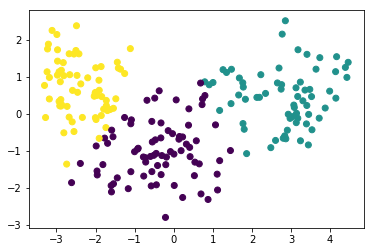

In [70]:
X, Y = load_dataset('seeds')
X = X.astype(np.float32)
X = normalize_dataset(X)
for i in range(1):
    C, V, m = sub_kmeans(X, 3, KERNEL=False)
    Pc = projection_matrices(X.shape[1], m)
    trans = V.T
    X_rotated = MM(trans[None, :, :], np.transpose(X[:, None, :], [0, 2, 1]))
    X_rotated = X_rotated.squeeze(-1).T
    acc = nmi(Y, C)
    print(m, acc)
    plt.scatter(X_rotated[0], X_rotated[1], c=C)
    plt.show()